In [2]:
import sys
import os
import importlib
import gc
import glob
import random
from itertools import combinations

import numpy as np
import sklearn
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import pyemma
import msmtools
import mdtraj as md

import ivac
import extq

In [3]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [4]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
cm_seq2 = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.8, dark=0.1, as_cmap=True, reverse=False
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

# Load data

In [5]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

In [6]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [7]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
# sb_trajs = []
# for i in range(6):
#     sb_trajs.extend(np.load(f'../../data/raw_feat/feat2_suppl_{i:02d}.npy', allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

In [8]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(3170017, 2) (3170017, 60)


# Delay embed CVs

In [9]:
n_embed = 20  # number of embeddings snapshots
delta = 10  # 1 ns, time between embedded snapshots

In [10]:
# use smaller input feature set
# R223-D129, R226-D129, R226-D186, R229-D129, R229-D186, R232-D186
sb_ids = [36, 42, 47, 48, 53, 59]
data_orig = [traj[:, sb_ids] for traj in sb_trajs]
embed_trajs = util.delay_embed(data_orig, n_embed, delta)
embed_arr = np.concatenate(embed_trajs)

print(data_orig[0].shape)
print(len(embed_trajs), embed_trajs[0].shape)
print(embed_arr.shape)

(10000, 6)
254 (9800, 126)
(3119217, 126)


## Lift states

In [11]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
# tic1 = livac_arr[:, 1]
# tic2 = livac_arr[:, 2]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [12]:
mask = ~(down_ids | up_ids)

# len(**_ids) is number of points in each state
down = sb_arr[down_ids]
up = sb_arr[up_ids]
other = sb_arr[mask]

# split CV data
down_cvs = cv_arr[down_ids]
up_cvs = cv_arr[up_ids]
other_cvs = cv_arr[mask]
down_sbs = sb_arr[down_ids]
up_sbs = sb_arr[up_ids]
other_sbs = cv_arr[mask]

In [13]:
assert (
    np.count_nonzero(down_ids) + np.count_nonzero(up_ids) + np.count_nonzero(mask)
) == len(cv_arr)
print(f"Number of down structures:  {len(down)}")
print(f"Number of up structures:   {len(up)}")
print(f"Number of other structures: {len(other)}")

Number of down structures:  31308
Number of up structures:   4614
Number of other structures: 3134095


In [14]:
traj_inds = util.split_indices(cv_trajs)

In [15]:
down_ind = np.zeros(len(cv_arr), dtype=np.float64)
down_ind[down_ids] = True
up_ind = np.zeros(len(cv_arr), dtype=np.float64)
up_ind[up_ids] = True

In [16]:
# delay embed indicator functions for states
lifted_up = util.lift_function(np.split(up_ind, traj_inds), n_embed, lag=delta)
lifted_down = util.lift_function(np.split(down_ind, traj_inds), n_embed, lag=delta)
print(len(lifted_up), lifted_up[0].shape)
print(len(lifted_down), lifted_down[0].shape)

254 (9800,)
254 (9800,)


In [17]:
# lift CV data
lifted_cvs = util.lift_function(cv_trajs, n_embed, lag=delta)
lifted_sbs = util.lift_function(sb_trajs, n_embed, lag=delta)
print(len(lifted_cvs), lifted_cvs[0].shape)
print(len(lifted_sbs), lifted_sbs[0].shape)
lifted_cv_arr = np.concatenate(lifted_cvs)
lifted_sb_arr = np.concatenate(lifted_sbs)

254 (9800, 2)
254 (9800, 60)


In [18]:
lifted_traj_inds = util.split_indices(embed_trajs)

# new up and upplus ids
# states in data
lifted_up_ids = np.concatenate(lifted_up).astype(bool)
lifted_down_ids = np.concatenate(lifted_down).astype(bool)
up_data = embed_arr[lifted_up_ids]
down_data = embed_arr[lifted_down_ids]
print(len(up_data), len(down_data))

4045 30343


In [19]:
random.seed(123)
skip = 10
N = len(embed_arr)
inds = random.sample(range(N), N // skip)

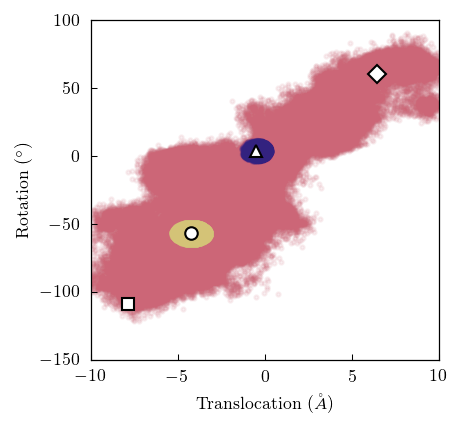

In [33]:
_ = plt.scatter(lifted_cv_arr[inds, 0], lifted_cv_arr[inds, 1], alpha=0.1)
_ = plt.scatter(*lifted_cv_arr[lifted_up_ids].T, alpha=0.1)
_ = plt.scatter(*lifted_cv_arr[lifted_down_ids].T, alpha=0.1)
ax = plt.gca()
plotting.format_cvs(ax, ms=6)

# Clustering

In [20]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

In [36]:
# cluster IVAC points with K-means
km = MiniBatchKMeans(n_clusters=1000)
km.fit(embed_arr)

MiniBatchKMeans(n_clusters=1000)

In [37]:
centers = km.cluster_centers_
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(centers)

NearestNeighbors(n_neighbors=1)

In [38]:
dtrajs = neighbors.kneighbors(embed_arr, return_distance=False)

In [39]:
dtrajs.shape

(3119217, 1)

In [40]:
np.save("../../data/delay_embed/sb6_1ns_20embed_anton2/dtrajs_1000.npy", dtrajs)

In [21]:
dtrajs = np.load("../../data/delay_embed/sb6_1ns_20embed_anton2/dtrajs_1000.npy")

## Basis/guess functions

In [22]:
basisL_arr = util.make_sparse_basis(np.squeeze(dtrajs))
basisF_arr = basisL_arr.copy()
lifted_mask = ~(lifted_up_ids | lifted_down_ids)
basisF_arr[~lifted_mask] = 0

traj_lens = [len(t) for t in embed_trajs]
basisL, basisF = [], []
curr = 0
for t_len in traj_lens:
    basisL.append(basisL_arr[curr : curr + t_len])
    basisF.append(basisF_arr[curr : curr + t_len])
    curr += t_len

print(len(basisL), basisL[0].shape)
print(len(basisL), basisF[0].shape)

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


254 (9800, 1000)
254 (9800, 1000)


In [23]:
guessU = lifted_up
guessD = lifted_down

# Weights

In [24]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

In [25]:
# cluster IVAC points with K-means
km200 = MiniBatchKMeans(n_clusters=200)
km200.fit(embed_arr)

MiniBatchKMeans(n_clusters=200)

In [26]:
centers = km200.cluster_centers_
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(centers)

NearestNeighbors(n_neighbors=1)

In [27]:
dtrajs2 = neighbors.kneighbors(embed_arr, return_distance=False)

In [28]:
basisL_arr = util.make_sparse_basis(np.squeeze(dtrajs2))
basisL = []
curr = 0
for t_len in traj_lens:
    basisL.append(basisL_arr[curr : curr + t_len])
    curr += t_len

print(len(basisL), basisL[0].shape)

254 (9800, 200)


In [29]:
weights = []
for lag in lags:
    weights.append(extq.dga.reweight(basisL, lag))

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


In [30]:
len(weights[0]), len(weights[0][0])

(254, 9800)

In [34]:
np.save("../../data/delay_embed/sb6_1ns_20embed_anton2/weights.npy", weights)

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


## PMFs

In [35]:
# PMFs
dist_trajs = [traj[:, 0] for traj in lifted_cvs]
rot_trajs = [traj[:, 1] for traj in lifted_cvs]
xlim = np.linspace(-10, 10, 50)
ylim = np.linspace(-150, 100, 50)

In [40]:
pmf = extq.projection.density2d(dist_trajs, rot_trajs, weights[0], xlim, ylim)

/tmp/jobs/17556991/ipykernel_252601/3250040818.py:9: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf.T) - min_energy


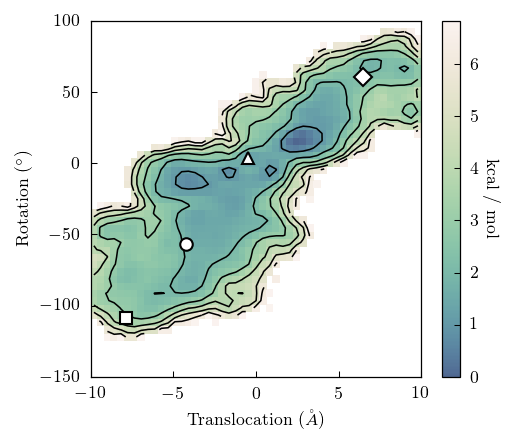

In [41]:
clines = np.linspace(0, 6, 7)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

f, ax = plt.subplots(figsize=(3.5, 3))

# calculate energy difference against minimum
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf.T) - min_energy
h = ax.pcolor(xlim, ylim, diff * 0.593, cmap=cm_seq)
cb = plt.colorbar(h, ax=ax)
cb.set_label("kcal / mol", rotation=-90, labelpad=10)
ax.contour(centerx, centery, diff * 0.593, levels=clines, colors="black")
plotting.format_cvs(ax, centroids=True, ms=6)
f.tight_layout()

In [42]:
sb_ids = [42, 48, 47, 53]

In [45]:
# PMFs in sb space
pmfs_sb = []
xlim = np.linspace(0.3, 2.0, 100)
ylim = np.linspace(0.3, 2.0, 100)
for (sb1, sb2) in combinations(sb_ids, 2):
    sb1_trajs = [traj[:, sb1] for traj in lifted_sbs]
    sb2_trajs = [traj[:, sb2] for traj in lifted_sbs]
    pmfs_sb.append(
        extq.projection.density2d(sb1_trajs, sb2_trajs, weights[2], xlim, ylim)
    )

/tmp/jobs/17556991/ipykernel_252601/3274754222.py:9: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(p.T) - min_energy


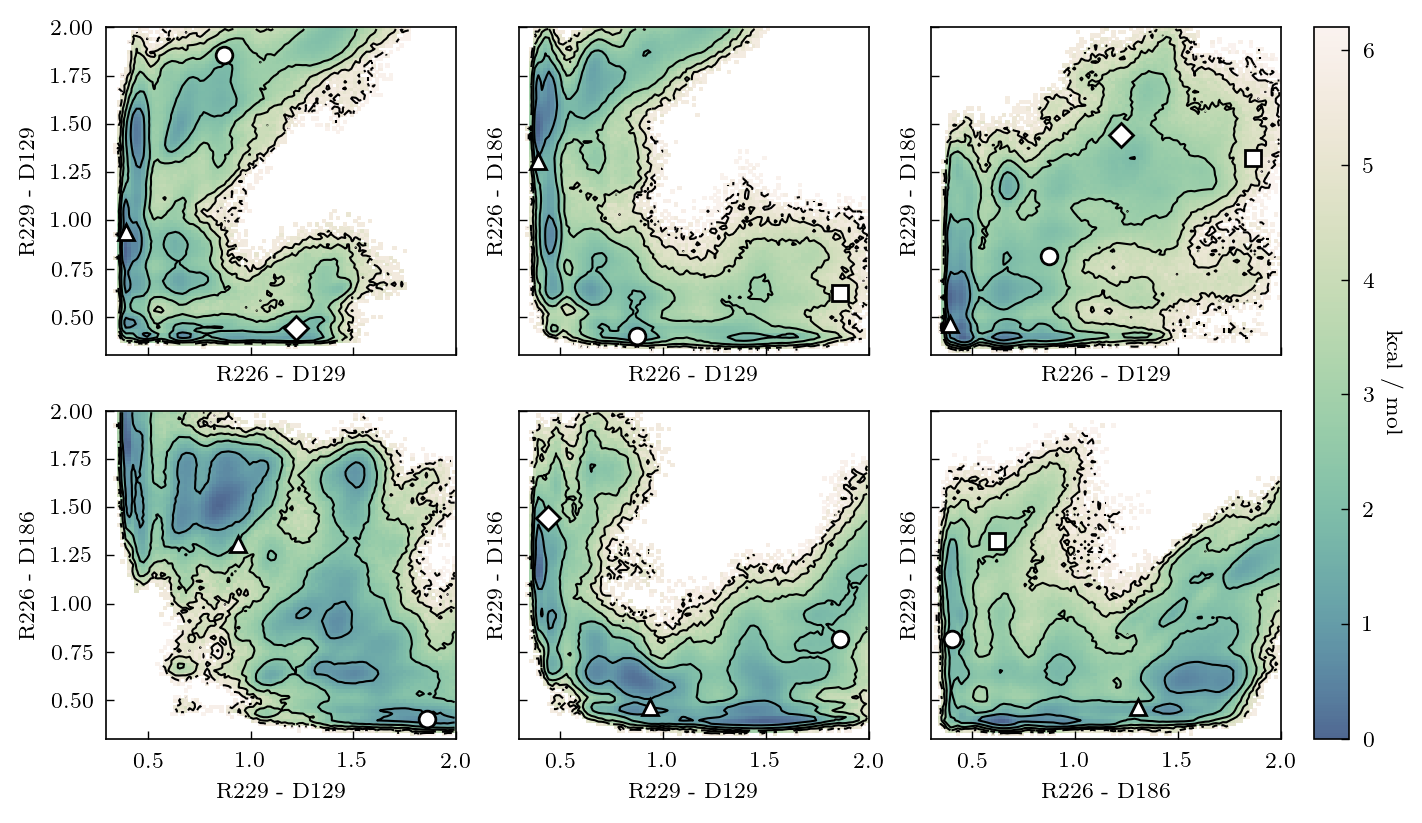

In [46]:
f, axes = plt.subplots(
    2, 3, figsize=(7, 4), sharex=True, sharey=True, constrained_layout=True, dpi=200
)

# compute grid
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2
for ((sb1, sb2), ax, p) in zip(combinations(sb_ids, 2), axes.flat, pmfs_sb):
    # calculate energy difference against minimum
    min_energy = np.min(-np.log(p[np.nonzero(p)]))
    diff = -np.log(p.T) - min_energy
    h = ax.pcolor(xlim, ylim, diff * 0.593, cmap=cm_seq)
    ax.contour(
        centerx,
        centery,
        diff * 0.593,
        levels=clines,
        colors="black",
        linestyles="solid",
    )
    ax.set_xlabel(f"{sb_labels[sb1 - 30]}")
    ax.set_ylabel(f"{sb_labels[sb2 - 30]}")

axes[0][0].set(xlim=[0.3, 2.0], ylim=[0.3, 2.0])
cb = plt.colorbar(h, ax=axes[:, -1])
cb.set_label("kcal / mol", rotation=-90, labelpad=10)
plotting.plot_sb_models(axes.flat, mode="du", centroids=True, ms=6)

# Committors

## Basis

In [47]:
import scipy

In [100]:
def orthogonalize(basis, pi):
    numer = 0
    denom = 0
    for b, p in zip(basis, pi):
        # numer += (b.T @ scipy.sparse.diags(p) @ b)
        numer += np.einsum("m,mi,mj->ij", p, b.A, b.A)
        denom += np.sum(p)
    evals, evecs = scipy.linalg.eigh(numer / denom)
    coeffs = evecs / np.sqrt(evals)[None, :]
    return [b @ coeffs for b in basis]

In [49]:
b = basisF[0]
p = weights[0][0]

In [50]:
b.shape, p.shape

((9800, 1000), (9800,))

In [51]:
s = np.einsum("m,mi,mj->ij", p, b.A, b.A)

In [57]:
s.shape

(1000, 1000)

In [58]:
ssp = b.T @ scipy.sparse.diags(p) @ b

In [ ]:
evalssp, evecs = scipy.sparse.linalg.eigsh(ssp / np.sum(p), k=999)
evals, _ = scipy.linalg.eigh(ssp.A / np.sum(p))

In [101]:
basis_d = orthogonalize(basisF, weights[0])

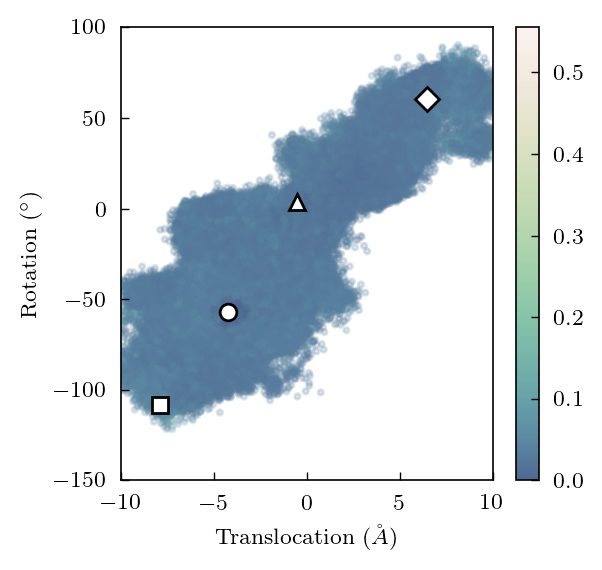

In [102]:
fig, ax = plt.subplots(dpi=200)
h = ax.scatter(
    lifted_cv_arr[inds, 0],
    lifted_cv_arr[inds, 1],
    c=np.mean(np.concatenate(basis_d), axis=-1)[inds],
    alpha=0.2,
    cmap=cm_seq,
)
cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1.0)
plotting.format_cvs(ax, ms=6)

In [107]:
np.save("../../data/delay_embed/sb6_1ns_20embed_anton2/basis_d.npy", basis_d)

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


## Calculations

In [103]:
in_domain = np.split(lifted_mask, lifted_traj_inds)
in_domain[0].shape

(9800,)

In [104]:
len(in_domain)

254

In [105]:
q_downup, qb_downup = [], []
for (lag, com) in zip(lags[:3], weights):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(extq.dga.forward_committor(basisF, com, in_domain, guessU, lag))
    qb_downup.append(extq.dga.backward_committor(basisF, com, in_domain, guessD, lag))

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5


In [108]:
np.save("../../data/delay_embed/sb6_1ns_20embed_anton2/q_downup.npy", q_downup)
np.save("../../data/delay_embed/sb6_1ns_20embed_anton2/qb_downup.npy", qb_downup)

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


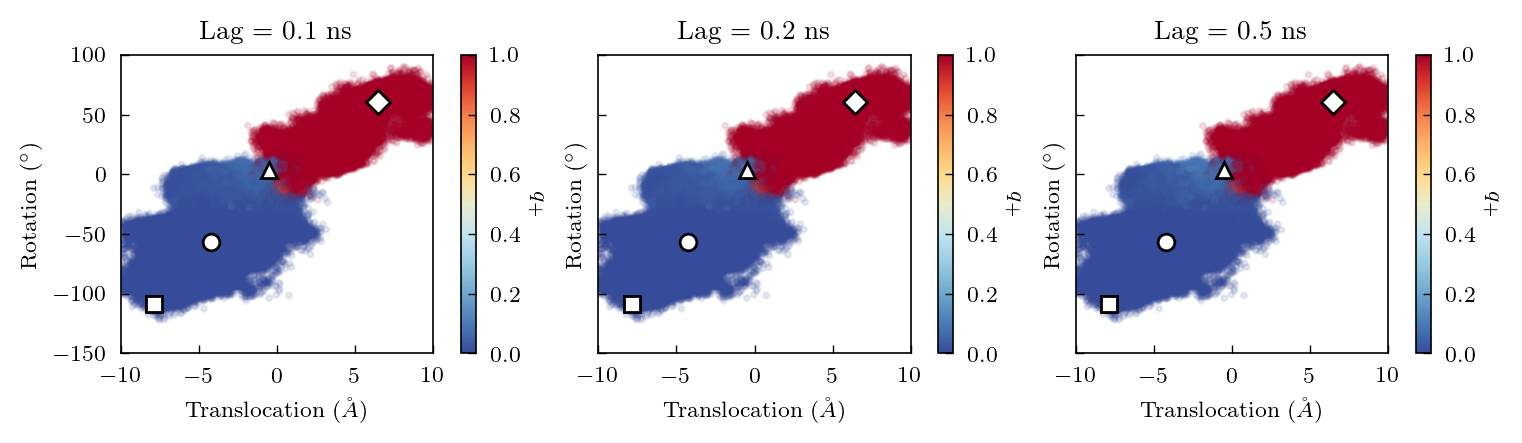

In [106]:
f, axs = plt.subplots(
    1, 3, figsize=(7.5, 2.1), sharex=True, sharey=True, dpi=200, constrained_layout=True
)
for lag, q, ax in zip(lags, q_downup, axs.flat):
    q_arr = np.concatenate(q).clip(min=0.0, max=1.0)
    h = ax.scatter(*lifted_cv_arr[inds].T, c=q_arr[inds], cmap=cm_div, alpha=0.1)
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    plotting.format_cvs(ax, centroids=True, ms=6)
    cbar.set_label("$q_+$", rotation=-90, labelpad=10)

/tmp/jobs/17556991/ipykernel_252601/2328813061.py:19: RuntimeWarning: invalid value encountered in true_divide
  h = ax.pcolor(xe, ye, (q_dens / w_dens).T, cmap=cm_div, vmin=0, vmax=1)


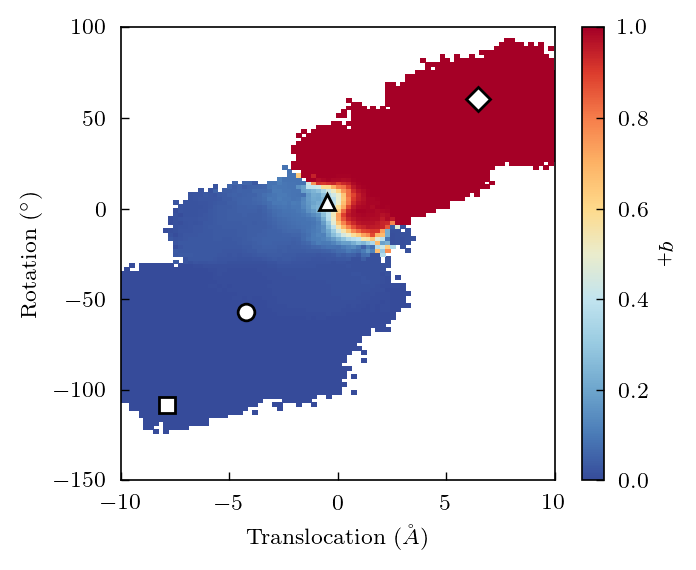

In [110]:
com = np.concatenate(weights[2])  # 20 ns lag
q_arr = np.concatenate(q_downup[2]).clip(min=0, max=1)
q_dens, xe, ye = np.histogram2d(
    lifted_cv_arr[:, 0],
    lifted_cv_arr[:, 1],
    bins=100,
    density=False,
    weights=q_arr * com,
)
w_dens, _, _ = np.histogram2d(
    lifted_cv_arr[:, 0], lifted_cv_arr[:, 1], bins=100, density=False, weights=com
)

f, ax = plt.subplots(figsize=(3.5, 3), dpi=200)
h = ax.pcolor(xe, ye, (q_dens / w_dens).T, cmap=cm_div, vmin=0, vmax=1)
cb = plt.colorbar(h, ax=ax)
cb.set_label("$q_+$", rotation=-90, labelpad=10)
plotting.format_cvs(ax, centroids=True, ms=6)

/tmp/jobs/17556991/ipykernel_252601/2605865932.py:12: RuntimeWarning: invalid value encountered in true_divide
  h = ax.pcolor(xe, ye, (qb_dens / w_dens).T, cmap=cm_div, vmin=0, vmax=1)


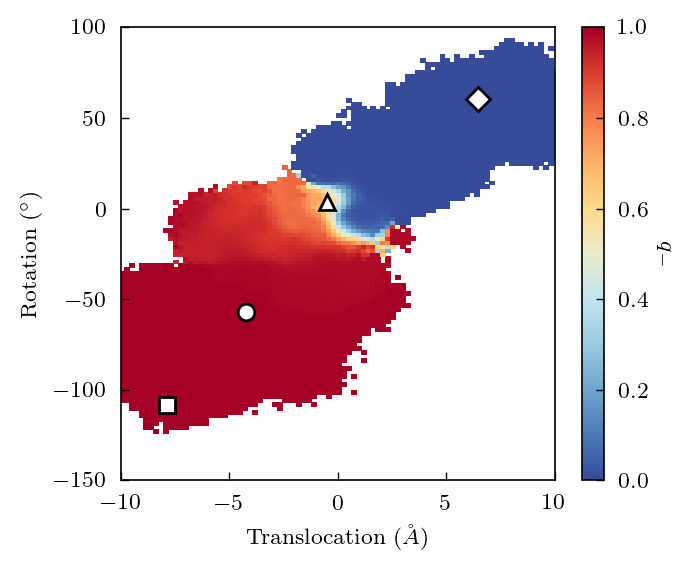

In [111]:
com = np.concatenate(weights[2])  # 20 ns lag
qb_arr = np.concatenate(qb_downup[2]).clip(min=0, max=1)
qb_dens, xe, ye = np.histogram2d(
    lifted_cv_arr[:, 0],
    lifted_cv_arr[:, 1],
    bins=100,
    density=False,
    weights=qb_arr * com,
)

f, ax = plt.subplots(figsize=(3.5, 3), dpi=200)
h = ax.pcolor(xe, ye, (qb_dens / w_dens).T, cmap=cm_div, vmin=0, vmax=1)
cb = plt.colorbar(h, ax=ax)
cb.set_label("$q_-$", rotation=-90, labelpad=10)
plotting.format_cvs(ax, centroids=True, ms=6)

In [112]:
centroids = np.loadtxt("../../models/MD-clustering-center/all.txt")

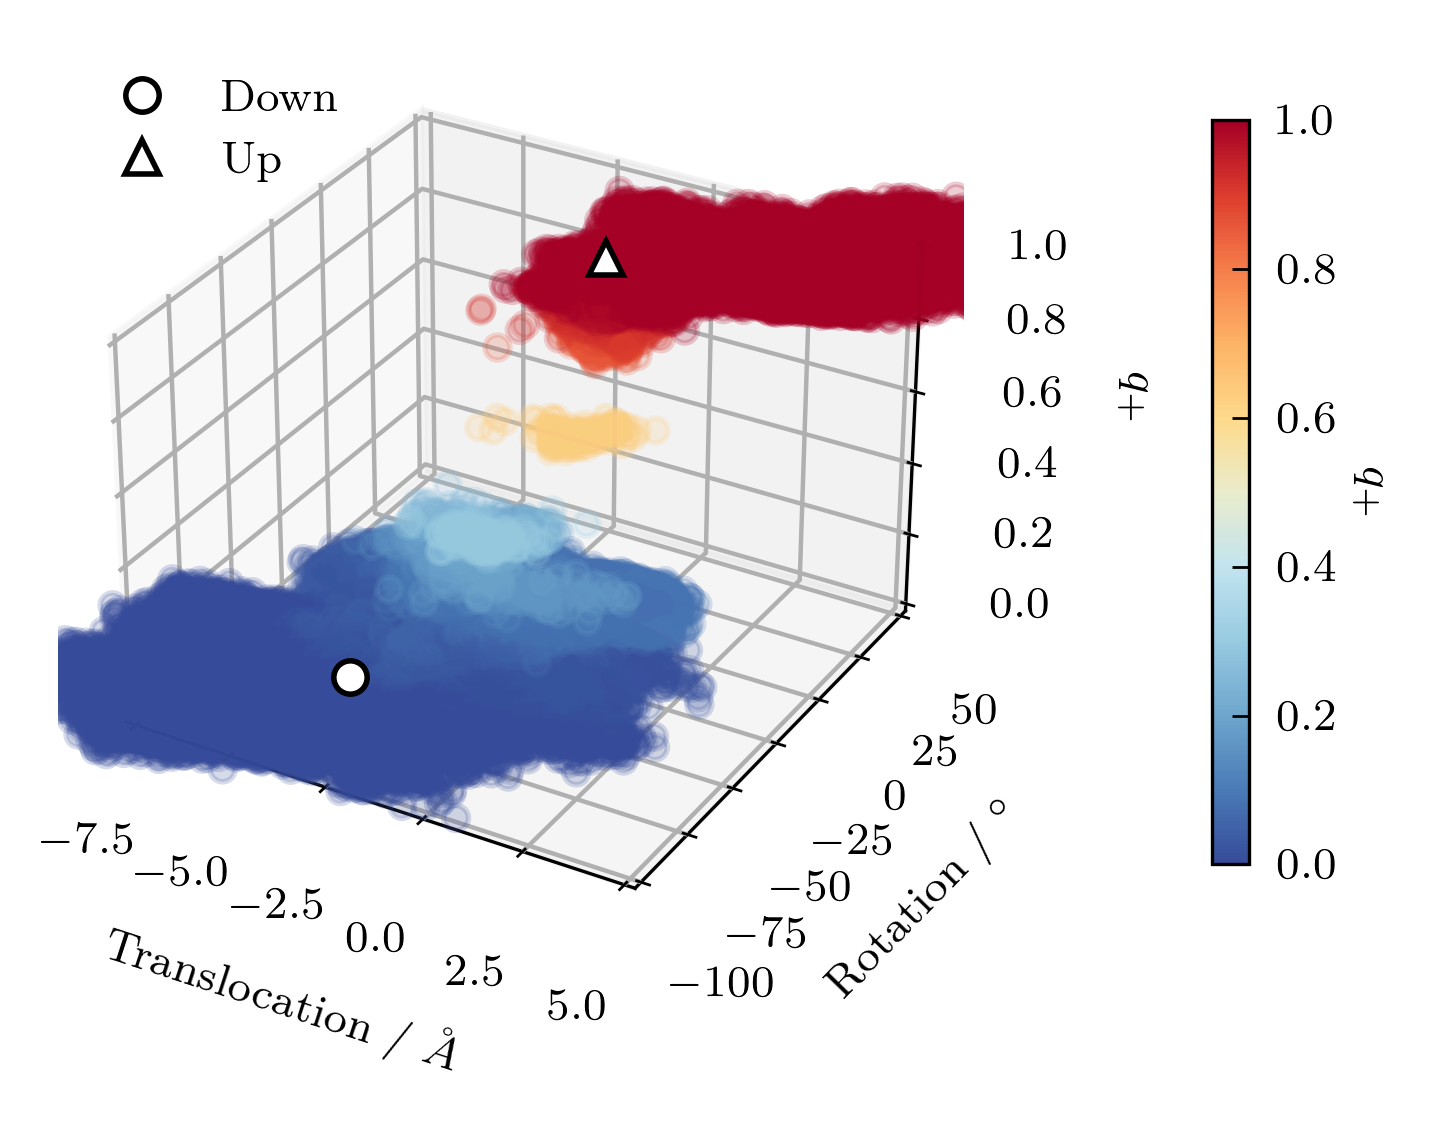

In [113]:
f = plt.figure(figsize=(4, 3), dpi=400)
ax = f.add_subplot(projection="3d")

q = np.concatenate(q_downup[2]).clip(min=0, max=1)
h = ax.scatter(
    lifted_cv_arr[inds, 0],
    lifted_cv_arr[inds, 1],
    q[inds],
    c=q[inds],
    cmap=cm_div,
    alpha=0.2,
)
ax.set_xlabel("Translocation / $\AA$")
ax.set_ylabel("Rotation / $^\circ$")
ax.zaxis.set_rotate_label(False)
ax.set_zlabel("$q_+$", rotation=-90)
ax.set_xlim([-7.5, 5])
ax.set_ylim([-100, 50])
ax.set_zlim([0, 1.0])
cbar = plt.colorbar(h, ax=ax, pad=0.2, fraction=0.03, label="$q_+$")
cbar.solids.set(alpha=1)
cbar.set_label("$q_+$", rotation=-90, labelpad=10)
# ax.set_title('Committor, down to up transition, 10 ns lag')

ax.grid(visible=True)
ax.plot(
    centroids[1, 0],
    centroids[1, 1],
    0,
    "o",
    mec="k",
    mfc="w",
    ms=6,
    zorder=5,
    label="Down",
)
ax.plot(
    centroids[2, 0],
    centroids[2, 1],
    1,
    "^",
    mec="k",
    mfc="w",
    ms=6,
    zorder=5,
    label="Up",
)
ax.legend(loc="upper left")
# plt.savefig("../../fig/committors/q_feat2_dist_du_suppl_dsq_5ns.png", dpi=300)

# TICA on delay-embedded vectors before clustering

In [114]:
embed_trajs[0].shape

(9800, 126)

In [115]:
livac = ivac.LinearIVAC(minlag=1, maxlag=9800, nevecs=10, addones=False, adjust=True)
livac.fit(embed_trajs)
ivac_trajs = livac.transform(embed_trajs)

In [116]:
len(ivac_trajs), ivac_trajs[0].shape

(254, (9800, 10))

In [117]:
np.save("../../data/delay_embed/sb6_1ns_20embed_anton2/ivac_trajs.npy", ivac_trajs)

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [119]:
ivac_arr = np.concatenate(ivac_trajs)

## Clustering

In [118]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

In [120]:
# cluster IVAC points with K-means
km = MiniBatchKMeans(n_clusters=1000)
km.fit(ivac_arr)

MiniBatchKMeans(n_clusters=1000)

In [121]:
centers = km.cluster_centers_
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(centers)

NearestNeighbors(n_neighbors=1)

In [122]:
dtrajs = neighbors.kneighbors(ivac_arr, return_distance=False)

In [123]:
dtrajs.shape

(3119217, 1)

In [124]:
np.save("../../data/delay_embed/sb6_1ns_20embed_anton2/dtrajs_ivac_1000.npy", dtrajs)

In [21]:
# dtrajs = np.load("../../data/delay_embed/sb6_1ns_20embed_anton2/dtrajs_1000.npy")

## Basis/guess functions

In [125]:
basisF_arr = util.make_sparse_basis(np.squeeze(dtrajs))
lifted_mask = ~(lifted_up_ids | lifted_down_ids)
basisF_arr[~lifted_mask] = 0

traj_lens = [len(t) for t in embed_trajs]
basisF = []
curr = 0
for t_len in traj_lens:
    basisF.append(basisF_arr[curr : curr + t_len])
    curr += t_len

print(len(basisF), basisF[0].shape)

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


254 (9800, 1000)


In [126]:
guessU = lifted_up
guessD = lifted_down

## Weights

In [127]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

In [128]:
# cluster IVAC points with K-means
km200 = MiniBatchKMeans(n_clusters=200)
km200.fit(ivac_arr)

MiniBatchKMeans(n_clusters=200)

In [129]:
centers = km200.cluster_centers_
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(centers)

NearestNeighbors(n_neighbors=1)

In [130]:
dtrajs2 = neighbors.kneighbors(ivac_arr, return_distance=False)

In [131]:
basisL_arr = util.make_sparse_basis(np.squeeze(dtrajs2))
basisL = []
curr = 0
for t_len in traj_lens:
    basisL.append(basisL_arr[curr : curr + t_len])
    curr += t_len

print(len(basisL), basisL[0].shape)

254 (9800, 200)


In [132]:
weights = []
for lag in lags:
    weights.append(extq.dga.reweight(basisL, lag))

In [133]:
len(weights[0]), len(weights[0][0])

(254, 9800)

In [134]:
np.save("../../data/delay_embed/sb6_1ns_20embed_anton2/weights_ivac_200.npy", weights)

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


## PMFs

In [135]:
# PMFs
dist_trajs = [traj[:, 0] for traj in lifted_cvs]
rot_trajs = [traj[:, 1] for traj in lifted_cvs]
xlim = np.linspace(-10, 10, 50)
ylim = np.linspace(-150, 100, 50)

In [136]:
pmf = extq.projection.density2d(dist_trajs, rot_trajs, weights[0], xlim, ylim)

/tmp/jobs/17556991/ipykernel_252601/3250040818.py:9: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf.T) - min_energy


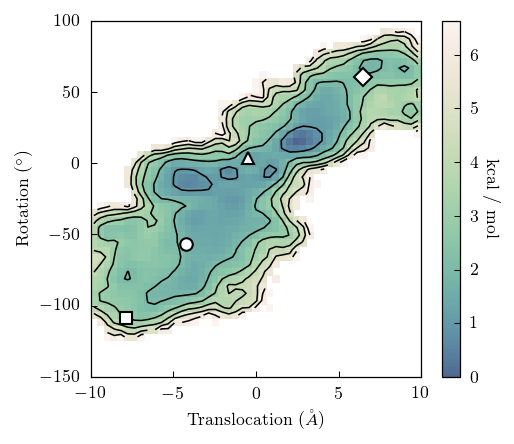

In [137]:
clines = np.linspace(0, 6, 7)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

f, ax = plt.subplots(figsize=(3.5, 3))

# calculate energy difference against minimum
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf.T) - min_energy
h = ax.pcolor(xlim, ylim, diff * 0.593, cmap=cm_seq)
cb = plt.colorbar(h, ax=ax)
cb.set_label("kcal / mol", rotation=-90, labelpad=10)
ax.contour(centerx, centery, diff * 0.593, levels=clines, colors="black")
plotting.format_cvs(ax, centroids=True, ms=6)
f.tight_layout()

In [138]:
sb_ids = [42, 48, 47, 53]

In [139]:
# PMFs in sb space
pmfs_sb = []
xlim = np.linspace(0.3, 2.0, 100)
ylim = np.linspace(0.3, 2.0, 100)
for (sb1, sb2) in combinations(sb_ids, 2):
    sb1_trajs = [traj[:, sb1] for traj in lifted_sbs]
    sb2_trajs = [traj[:, sb2] for traj in lifted_sbs]
    pmfs_sb.append(
        extq.projection.density2d(sb1_trajs, sb2_trajs, weights[2], xlim, ylim)
    )

/tmp/jobs/17556991/ipykernel_252601/3274754222.py:9: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(p.T) - min_energy


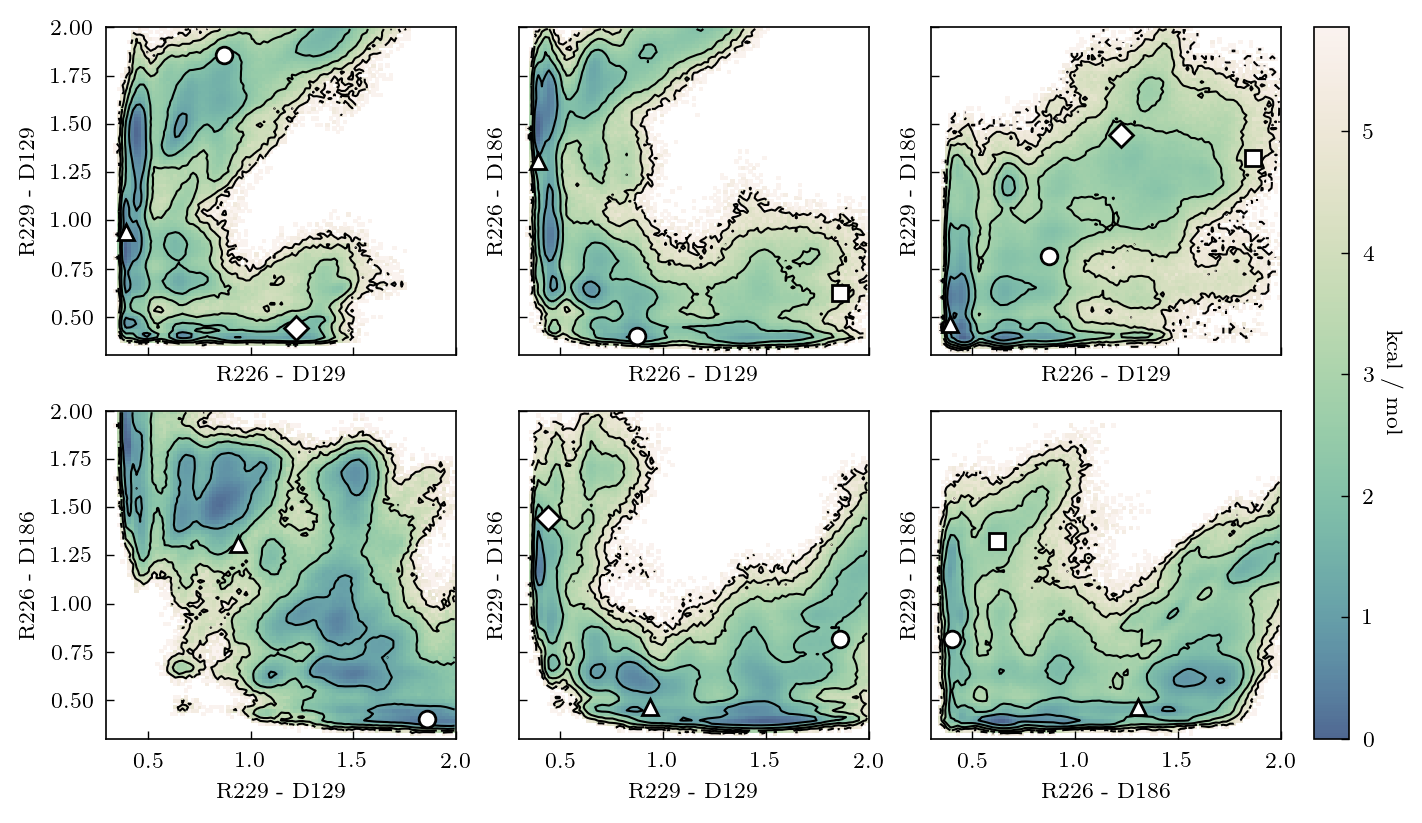

In [140]:
f, axes = plt.subplots(
    2, 3, figsize=(7, 4), sharex=True, sharey=True, constrained_layout=True, dpi=200
)

# compute grid
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2
for ((sb1, sb2), ax, p) in zip(combinations(sb_ids, 2), axes.flat, pmfs_sb):
    # calculate energy difference against minimum
    min_energy = np.min(-np.log(p[np.nonzero(p)]))
    diff = -np.log(p.T) - min_energy
    h = ax.pcolor(xlim, ylim, diff * 0.593, cmap=cm_seq)
    ax.contour(
        centerx,
        centery,
        diff * 0.593,
        levels=clines,
        colors="black",
        linestyles="solid",
    )
    ax.set_xlabel(f"{sb_labels[sb1 - 30]}")
    ax.set_ylabel(f"{sb_labels[sb2 - 30]}")

axes[0][0].set(xlim=[0.3, 2.0], ylim=[0.3, 2.0])
cb = plt.colorbar(h, ax=axes[:, -1])
cb.set_label("kcal / mol", rotation=-90, labelpad=10)
plotting.plot_sb_models(axes.flat, mode="du", centroids=True, ms=6)

## Committors

### Whiten Basis

In [141]:
import scipy

In [142]:
basis_d = orthogonalize(basisF, weights[0])

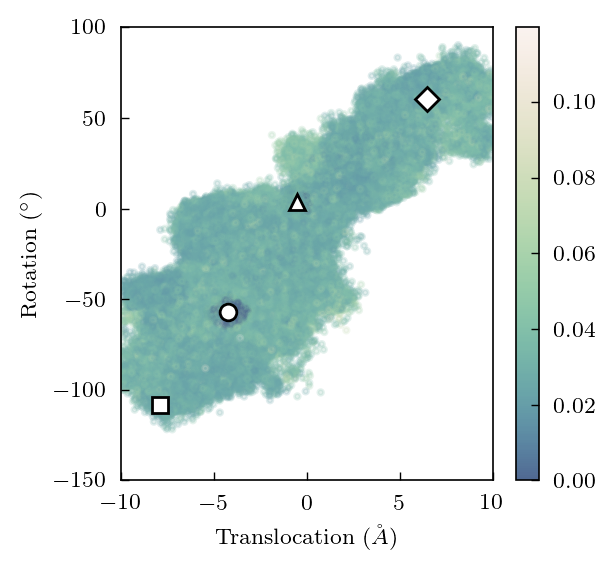

In [143]:
fig, ax = plt.subplots(dpi=200)
h = ax.scatter(
    lifted_cv_arr[inds, 0],
    lifted_cv_arr[inds, 1],
    c=np.mean(np.concatenate(basis_d), axis=-1)[inds],
    alpha=0.2,
    cmap=cm_seq,
)
cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1.0)
plotting.format_cvs(ax, ms=6)

In [144]:
np.save("../../data/delay_embed/sb6_1ns_20embed_anton2/basis_d_200.npy", basis_d)

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


### Calculations

In [145]:
in_domain = np.split(lifted_mask, lifted_traj_inds)
in_domain[0].shape

(9800,)

In [146]:
len(in_domain)

254

In [147]:
q_downup, qb_downup = [], []
for (lag, com) in zip(lags[:3], weights):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(extq.dga.forward_committor(basisF, com, in_domain, guessU, lag))
    qb_downup.append(extq.dga.backward_committor(basisF, com, in_domain, guessD, lag))

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5


In [148]:
np.save("../../data/delay_embed/sb6_1ns_20embed_anton2/q_downup_ivac.npy", q_downup)
np.save("../../data/delay_embed/sb6_1ns_20embed_anton2/qb_downup_ivac.npy", qb_downup)

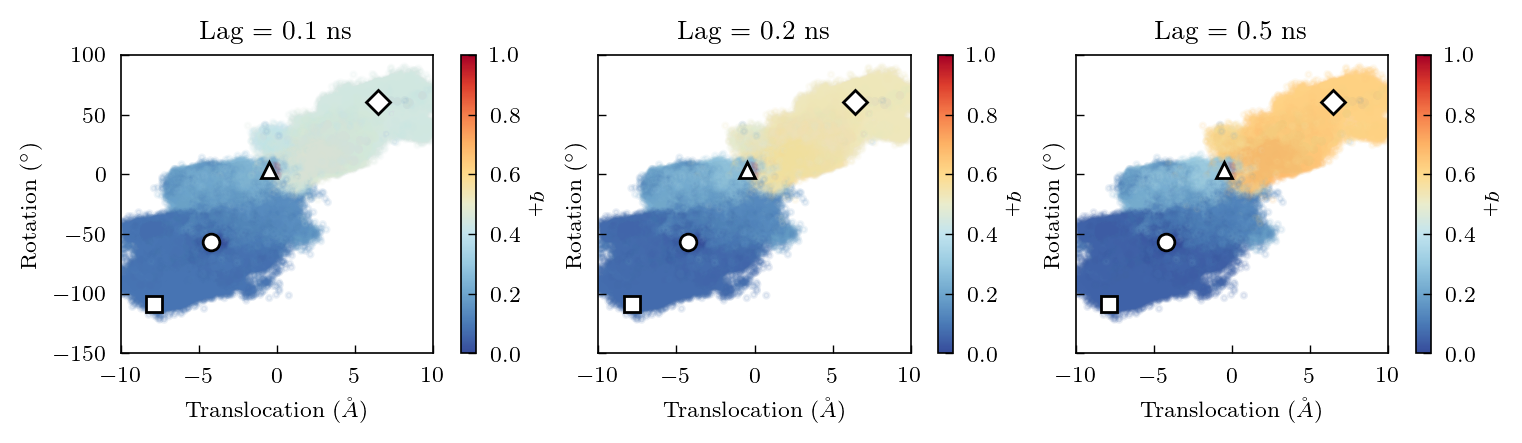

In [149]:
f, axs = plt.subplots(
    1, 3, figsize=(7.5, 2.1), sharex=True, sharey=True, dpi=200, constrained_layout=True
)
for lag, q, ax in zip(lags, q_downup, axs.flat):
    q_arr = np.concatenate(q).clip(min=0.0, max=1.0)
    h = ax.scatter(*lifted_cv_arr[inds].T, c=q_arr[inds], cmap=cm_div, alpha=0.1)
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    plotting.format_cvs(ax, centroids=True, ms=6)
    cbar.set_label("$q_+$", rotation=-90, labelpad=10)

# Chatipat's method (remove linear combinations before embedding)

In [151]:
# 6 dimensional original data (salt bridges)
pca0 = pyemma.coordinates.pca(data=data_orig, dim=1)

calc mean+cov:   0%|          | 0/254 [00:00<?, ?it/s]

In [164]:
g0 = pca0.transform(data_orig)

In [189]:
# f1 = [traj[:-1*delta] for traj in data_orig]
f1 = delay(g0, 1, 10, delta)
f1_pg0 = pca0.transform(f1)
f1 = [(tf - tg) for tf, tg in zip(f1, f1_pg0)]

In [190]:
pca1 = pyemma.coordinates.pca(data=f1, dim=1)
g1 = pca1.transform(f1)

calc mean+cov:   0%|          | 0/254 [00:00<?, ?it/s]

In [191]:
# f2 = [traj[:-2*delta] for traj in g1]
f2 = delay(g1, 2, 10, delta)
f2_pg1 = pca1.transform(f2)
f2 = [(tf - tg) for tf, tg in zip(f2, f2_pg1)]

In [184]:
def delay(tlist, n, max_embed, lag):
    embed_tlist = []
    for traj in tlist:
        N_i = len(traj)
        if N_i - (lag * n) <= 0:
            continue
        start_ix = lag * (max_embed - n)
        stop_ix = N_i - (lag * n)
        embed_tlist.append(traj[start_ix:stop_ix])
    return embed_tlist

In [ ]:
def embed_reduce(tlist, max_embed, lag):
    embed_tlist = []
    f = tlist
    g_list = []
    for i in range(max_embed):
        # compute most important PCA eigenvector
        pca = pyemma.coordinates.pca(data=f, dim=1)
        g = pca.transform(f)
        g_list.append(g)
        
        # delay 
        f_next = delay(g, i, max_embed, lag)
        
        # remove span of g
        f = remove_span(f_next, g_list)
    return g_list
        
def remove_span(tlist, vectors):
    """Remove span of each of the vectors from
    a given dataset
    """
    for traj in tlist:
        for v in vectors:
            